# Training Attempt 2


In [273]:
import os
from typing import List, Dict, Tuple

import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchaudio
torchaudio.set_audio_backend("sox_io")

from beat2d import settings

In [3]:
DATASET_PATH = "../data/oneshots"
CLASSES = {"kick": 0, "snare": 1}

# Dataset

## Loading the Dataset

In [92]:
def load_dataset(dataset_path: str, classes: List[str]) -> Tuple[List[np.ndarray], List[str]]:
    data: List[np.ndarray] = []
    labels: List[str] = []
    
    for cls in classes:
        class_dir = os.path.join(DATASET_PATH, cls)
        class_dir = os.path.abspath(class_dir)
        
        if not os.path.isdir(class_dir):
            raise ValueError(f"No folder {cls} in {dataset_path}")
        
        for fname in os.listdir(class_dir):
            sample, sample_rate = librosa.core.load(os.path.join(class_dir, fname), settings.SAMPLE_RATE)
            data.append(sample)
            labels.append(LABELS[cls])
    
    return data, np.array(labels, dtype=np.int8)

In [93]:
data, labels = load_dataset(DATASET_PATH, CLASSES)

## Trimming Samples

In this step we are doing prelimiary trimming of the data to get an idea of the actual length of the samples.

In [94]:
for i, d in enumerate(data):
    d_trim, _ = librosa.effects.trim(d, top_db=25)
    data[i] = d_trim

## Analyzing the Samples in the Dataset

First I want to take a look at the average length of samples.

In [95]:
lengths = np.ndarray((len(data),), dtype=np.float32)
for i, d in enumerate(data):
    lengths[i] = librosa.get_duration(d, settings.SAMPLE_RATE)

In [96]:
print(
    "max:", lengths.max(),
    "min:", lengths.min(),
    "mean:", lengths.mean()
)

max: 1.0448979 min: 0.054875284 mean: 0.2790546


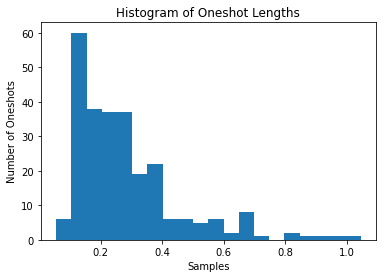

In [97]:
plt.title("Histogram of Oneshot Lengths")
plt.xlabel("Samples")
plt.ylabel("Number of Oneshots")
plt.hist(lengths, bins=20)
plt.show()

In [98]:
librosa.core.time_to_samples(0.4, settings.SAMPLE_RATE)

8820

Looking at the histogram above, I'm comfortable clipping the oneshots at 0.4 seconds, which is 8820 samples. For the samples that are shorter than 0.4, we zero pad.

In [122]:
MAX_LENGTH = 8820

for i, d in enumerate(data):
    d_clipped = np.zeros((MAX_LENGTH,))
    d_clipped[:min(MAX_LENGTH, len(d))] = d[:min(MAX_LENGTH, len(d))]
    data[i] = d_clipped

data = np.array(data, dtype=np.float32)

In [123]:
lengths = np.ndarray((len(data),), dtype=np.float32)
for i, d in enumerate(data):
    lengths[i] = librosa.get_duration(d, settings.SAMPLE_RATE)

print(
    "max:", lengths.max(),
    "min:", lengths.min(),
    "mean:", lengths.mean()
)

max: 0.4 min: 0.4 mean: 0.40000004


# Computing Features

Next we'll use torchaudio to generate our features from the audio. I chose to use MEL Spectrograms to transform my data into another feature space.

In [124]:
kicks = data[labels == 0]
snares = data[labels == 1]

In [422]:
def mel_spectrogram_layer(sr: int = settings.SAMPLE_RATE):
    return torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_mels=40,
        normalized=True
    )

def compute_features(sample: np.ndarray, sr: int = settings.SAMPLE_RATE):
    return mel_spectrogram_layer()(torch.from_numpy(sample))

(8820,)
torch.Size([40, 45])


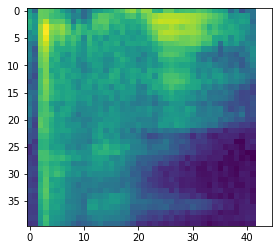

In [423]:
idx = 10

kick_melspec = compute_features(kicks[idx])
print(kicks[idx].shape)
print(kick_melspec.shape)
plt.imshow(kick_melspec.log2().detach().numpy())

(8820,)
torch.Size([40, 45])


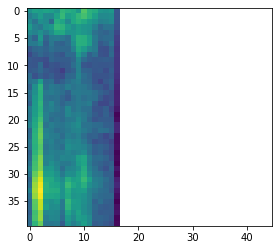

In [424]:
idx = 120

snare_melspec = compute_features(snares[idx])
print(snares[idx].shape)
print(snare_melspec.shape)
plt.imshow(snare_melspec.log2().detach().numpy())

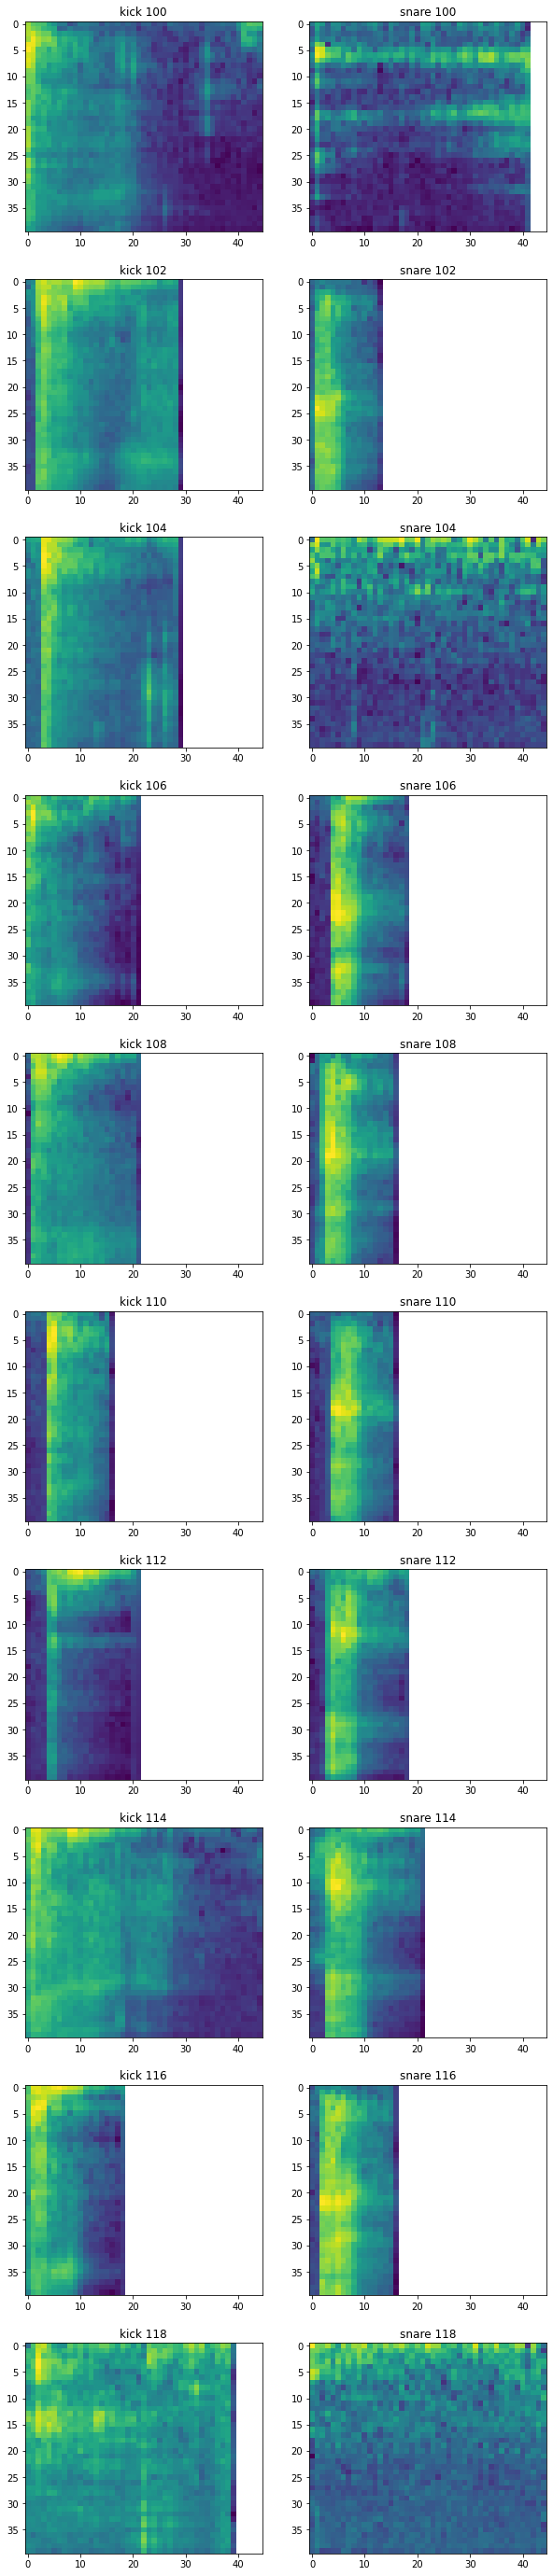

In [425]:
rows = 10
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 50))
axes = axes.flatten()

sample_offset = 100
for i_ax in range(0, rows*cols, 2):
    sample_idx = i_ax + sample_offset
    k_spec = compute_features(kicks[sample_idx])
    s_spec = compute_features(snares[sample_idx])
    
    axes[i_ax].set_title(f"kick {sample_idx}")
    axes[i_ax].imshow(k_spec.log2().detach().numpy())
    
    axes[i_ax+1].set_title(f"snare {sample_idx}")
    axes[i_ax+1].imshow(s_spec.log2().detach().numpy())

A human could probably identify each type of sample using the Mel Spectrogram, so our model should be pretty good at it too!

Viewing these, we clearly have different quality data.

In [426]:
# Great sample
ipd.Audio(kicks[114], rate=settings.SAMPLE_RATE)

In [427]:
# Poor sample
ipd.Audio(kicks[118], rate=settings.SAMPLE_RATE)

In [428]:
# Great sample
ipd.Audio(snares[112], rate=settings.SAMPLE_RATE)

In [429]:
# Poor sample
ipd.Audio(snares[100], rate=settings.SAMPLE_RATE)

# Building our Model

For this model, I'm going to use a base model of VGG16. Although in technology years, it's pretty old, it's also quite a simple model, and commonly used for image recognition.

In [430]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)

        self.fc1 = nn.Linear(16 * 8 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [431]:
net = Net()

In [432]:
net(kick_melspec.view(1, 1, 40, 45))

tensor([-0.0971], grad_fn=<AddBackward0>)

In [437]:
np.array([compute_features(d).numpy() for d in data]).max()

82.1672

In [441]:
sample = kicks[0]

In [442]:
norm_sample = (sample - sample.mean()) / sample.std()

In [445]:
norm_sample.mean()

1.0812634e-08